# Izrada modela i evaluacija: Klasifikacija teksta

---

## 1. Uvoz knjižnica i postavke

In [1]:
# Knjižnice (Python 3.10.0)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

---

## 2. Priprema skupa podataka

In [3]:
file_path = './datasets/dataset_clean/dataset_clean.csv'
dataset = pd.read_csv(file_path)

In [4]:
VOCAB_SIZE = 10000
MAX_LENGTH = 256
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(dataset["description"])
sequences = tokenizer.texts_to_sequences(dataset["description"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [5]:
glove_path = "./utils/glove/glove.6B.100d.txt"
embedding_dim = 100

embeddings_index = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [6]:
word_index = tokenizer.word_index
vocab_size = min(len(word_index) + 1, VOCAB_SIZE)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

---

## 3. Definiranje i treniranje modela

In [7]:
X = np.array(padded_sequences)
y = np.array(dataset["category_encoded"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=4),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
checkpoint_path = "./models/model_classification_text.keras"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
  X_train, 
  y_train, 
  epochs=30, 
  batch_size=32, 
  validation_split=0.2,
  callbacks=[early_stopping, model_checkpoint]
  )

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2104 - loss: 1.6050
Epoch 1: val_accuracy improved from -inf to 0.40425, saving model to ./models/model_classification_text.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.2104 - loss: 1.6050 - val_accuracy: 0.4042 - val_loss: 1.2860
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5786 - loss: 0.9966
Epoch 2: val_accuracy improved from 0.40425 to 0.88500, saving model to ./models/model_classification_text.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5787 - loss: 0.9963 - val_accuracy: 0.8850 - val_loss: 0.3767
Epoch 3/30
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8844 - loss: 0.3810
Epoch 3: val_accuracy improved from 0.88500 to 0.91875, saving model to ./models/model_classification_text.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8844 - loss: 0.3810 - val_accuracy: 0.9187 - val_loss: 0.2883
Epoch 4/30
 998/1000 ━━━━━━━━━━━━━

---

## 4. Evaluacija i vizualizacija modela

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9262 - loss: 0.3497


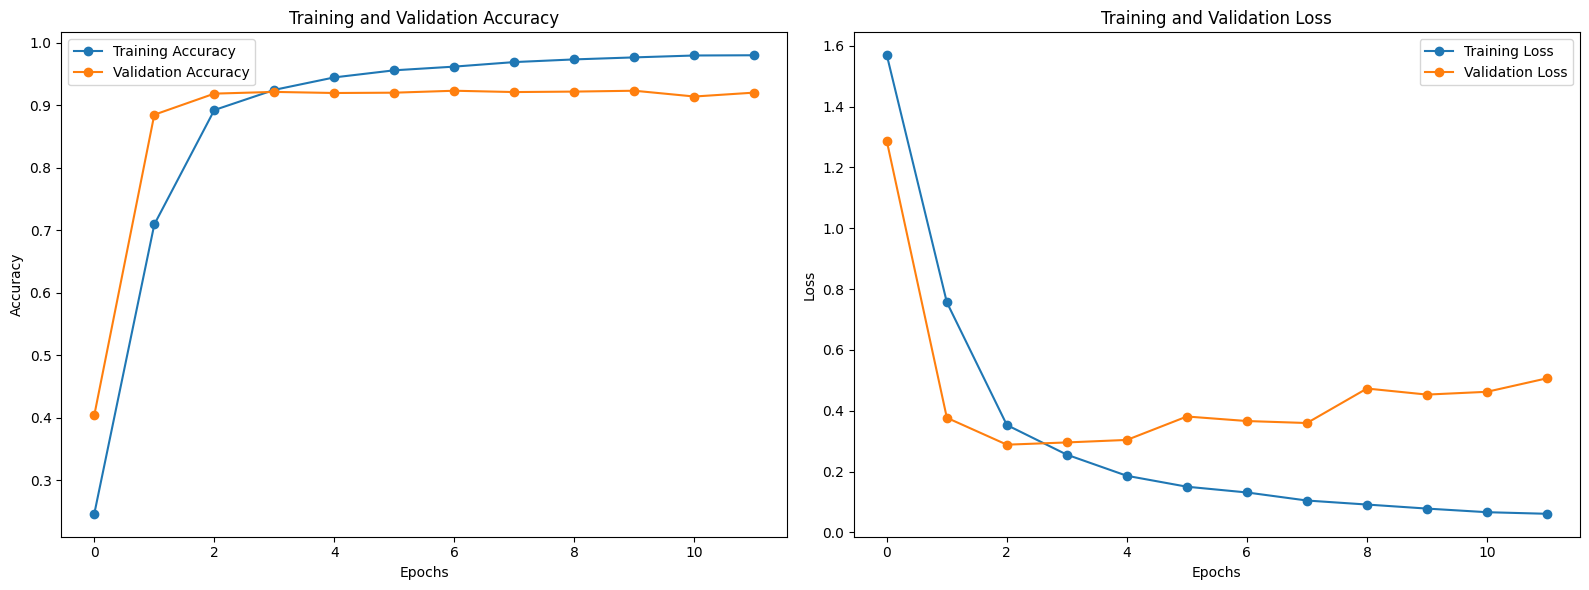

Test loss: 0.3493
Test accuracy: 0.9271


In [10]:
loss, accuracy = model.evaluate(X_test, y_test)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

---

## 5. Testiranje modela na proizvoljnim opisima proizvoda

In [11]:
# Kategorija za predloženi tekst je "Baby"
new_text = "with just three simple clicks your baby stroller is ready for two even with the side by side configuration the double stroller will still fit through standard doorways so getting out and about feels all the more manageable from groceries to toys for your child the handy side luggage basket is ideal for those grab and go moments"

categories = {
  0: "Amazon Home",
  1: "Automotive",
  2: "Baby",
  3: "Pet Supplies",
  4: "Sports & Outdoors",
}

new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=MAX_LENGTH, padding='post')
predicted_class = np.argmax(model.predict(new_padded), axis=-1)[0]

print(f"Predviđena kategorija: {categories[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predviđena kategorija: Baby
